Bernoulli trials are one of the simplest experimential setups: there are a number of iterations of some activity, where each iteration (or trial) may turn out to be a "success" or a "failure". From the data on T trials, we want to estimate the probability of "success".

Since it is such a simple case, it is a nice setup to use to describe some of Python's capabilities for estimating statistical models. Here I show estimation from the classical (frequentist) perspective via maximum likelihood estimation

There is also a slight digression about the delta method (which can be used to approximate the variance / covariance matrix when numeric maximum likelihood estimation is employed).

In [another post](./bernoulli_trials_bayesian.html) I show estimation of the problem in Python using a Bayesian approach.

<!-- TEASER_END -->

In [18]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import statsmodels.api as sm
import sympy as sp
import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma

from sympy.interactive import printing
printing.init_printing()

### Setup

Let $y$ be a Bernoulli trial:

$y \sim \text{Bernoulli}(\theta) = \text{Binomial}(1, \theta)$

The probability density, or marginal likelihood, function, is:

$$p(y|\theta) = \theta^{y} (1-\theta)^{1-y} = \begin{cases}
\theta & y = 1 \\
1 - \theta & y = 0
\end{cases}$$

In [19]:
# Simulate data
np.random.seed(123)

nobs = 100
theta = 0.3
Y = np.random.binomial(1, theta, nobs)

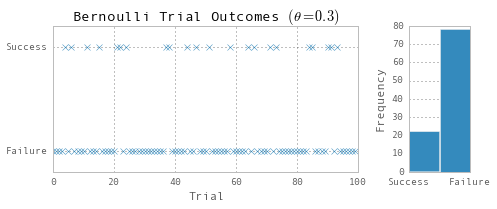

In [20]:
# Plot the data
fig = plt.figure(figsize=(7,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(range(nobs), Y, 'x')
ax2.hist(-Y, bins=2)

ax1.yaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Success', 'Failure'));

ax1.set(title=r'Bernoulli Trial Outcomes $(\theta=0.3)$', xlabel='Trial', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()

### Likelihood function

Consider a sample of $T$ draws from the random variable $y$. The joint likelihood of observing any specific sample $Y = (y_1, ..., y_T)'$ is given by:

$$
\begin{align}
p(Y|\theta) & = \prod_{i=1}^T \theta^{y_i} (1-\theta)^{1-y_i} \\
& = \theta^{s} (1 - \theta)^{T-s}
\end{align}
$$

where $s = \sum_i y_i$ is the number of observed "successes", and $T-s$ is the number of observed "failures".

### Maximum Likelihood Estimation

Since we have a likelihood function, we can maximize it, as in the classical framework.

#### Analytically

In fact, the likelihood function here can be maximized analytically ([see details](#analytic_mle)):

$$
\begin{align}
L(\theta;Y) & = \theta^{s} (1 - \theta)^{T-s} & \text{Likelihood} \\
\log L(\theta;Y) & = s \log \theta + (T - s) \log (1 - \theta) & \text{Log-likelihood} \\
\frac{\partial \log L(\theta;Y)}{\partial \theta} & = s \theta^{-1} - (T-s)(1-\theta)^{-1} & \text{Score} \\
H(\theta) = \frac{\partial^2 \log L(\theta;Y)}{\partial \theta^2} & = -s \theta^{-2} - (T-s)(1-\theta)^{-2} & \text{Hessian} \\
I[\theta] = -E\left [ H(\theta) \right ] & = \frac{T}{\theta (1 - \theta)} & \text{Information} \\
I[\theta]^{-1} & = \frac{\theta (1-\theta)}{T} & \text{Variance/Covariance}
\end{align}
$$

In [21]:
t, T, s = sp.symbols('theta, T, s')

# Create the functions symbolically
likelihood = (t**s)*(1-t)**(T-s)
loglike = s*sp.log(t) + (T-s)*sp.log(1-t)
score = (s/t) - (T-s)/(1-t)
hessian = -s/(t**2) - (T-s)/((1-t)**2)
information = T / (s*(1-s))
var = 1/information

# Convert them to Numpy-callable functions
_likelihood = sp.lambdify((t,T,s), likelihood, modules='numpy')
_loglike = sp.lambdify((t,T,s), loglike, modules='numpy')
_score = sp.lambdify((t,T,s), score, modules='numpy')
_hessian = sp.lambdify((t,T,s), hessian, modules='numpy')

The first-order condition tells us that the log-likelihood is maximized ([see details](#foc)) when:
$$
\begin{align}
0 & = \left . \frac{\partial \log L(\theta;Y)}{\partial \theta} \right |_{\hat \theta_\text{MLE}} \implies \hat \theta_\text{MLE} = \frac{s}{T} \\
\end{align}
$$

To make sure we're at a maximum, we can check the second order condition (note that $T > s$):
$$
\begin{align}
\left . \frac{\partial^2 \log L(\theta;Y)}{\partial \theta^2} \right |_{\hat \theta_\text{MLE}} & = -s (s/T)^{-2} - (T-s)(1-s/T)^{-2} < 0\\
\end{align}
$$

In [22]:
# Find the optimal theta_hat using the analytic solution
theta_hat_analytic = Y.sum() / nobs
var_analytic = (theta_hat_analytic * (1 - theta_hat_analytic)) / nobs
print('Analytic MLE Results: %.2f (%.10f)' % (theta_hat_analytic, var_analytic**0.5))

Analytic MLE Results: 0.22 (0.0414246304)


#### Numeric MLE: Transformations and the The Delta Method

In many situations, we won't be able to analytically solve the maximization. In those cases we can use numeric optimization techniques. In Python we can use function from `scipy.optimize`.

The first thing to note is that these functions are minimizers, so we'll actually be minimizing the negative of the likelihood function.

The second thing to note about numeric optimization is that the optimizers are often over an unconstrained parameter space, meaning that they will find the vector in $\mathbb{R^k}$ (if you're optimizing over $k$ parameters). This is a problem in many cases, including this one since our likelihood function is a function of $\theta \in (0,1)$. To get around this, we need to optimize over a transformed parameter that can take any value on the real line, and then map the parameter given to us by the optimizer to an appropriate value. We will use:

$$\theta = g(\varphi) = \frac{e^\varphi}{1 + e^\varphi}, \quad \varphi \in \mathbb{R}$$

The next thing to note is that we need to use the negative inverse of the hessian to calculate the variance / covariance matrix, but in general we won't have the analytic hessian matrix (if we did, we wouldn't need to do numeric optimization). Fortunately, some optimization routines (e.g. `scipy.optimize.fmin_bfgs`) will return the numeric approximation to the hessian, which we can use to get the variance / covariance matrix.

The final issue is that the variance / covariance matrix from the approximated hessian will be for the _unconstrained_ parameter $\varphi$ rather than the parameter of interest $\theta$. To get around this, we can use the delta method to recover the variance / covariance matrix of interest:

$$
\text{Cov}(\theta) = \left . \frac{\partial g(\varphi)}{\partial \varphi} \right |_{\varphi_\text{MLE}} \times \text{Cov}({\varphi}) \times \left . \frac{\partial g(\varphi)}{\partial \varphi}^T \right |_{\varphi_\text{MLE}}
$$

For the transformation function above, the derivative we need ([see details](#trans_grad)) is:

$$
\begin{align}
\frac{\partial g(\varphi)}{\partial \varphi} = \frac{e^\varphi}{(1 + e^\varphi)^2}\\
\end{align}
$$

Since we have analytic results available, we can actually prove that the Delta method works:

First, note that there exists an inverse ([see details](#trans_inv)) to $g$:

$$
\begin{align}
\varphi = g^{-1}(\theta) = \log \left (\frac{\theta}{1 - \theta} \right ) \\
\end{align}
$$

Since we solved the MLE analytically, we can get the optimizing parameters:

$$
\begin{align}
\hat \theta_\text{MLE} & = \frac{s}{T} \\
\hat \varphi_\text{MLE} & = g^{-1}(\hat \theta_\text{MLE}) = \log \left (\frac{\hat \theta_\text{MLE}}{1 - \hat \theta_\text{MLE}} \right ) = \log \left (\frac{s}{T-s} \right )
\end{align}
$$

We can restate the system in terms of the unconstrained parameter $\varphi$ ([see details](#mle_uncon)):

$$
\begin{align}
L(g(\varphi);Y) & = g(\varphi)^{s} (1 - g(\varphi))^{T-s} & \text{Likelihood} \\
\log L(g(\varphi);Y) & = s \log g(\varphi) + (T - s) \log (1 - g(\varphi)) & \text{Log-likelihood} \\
\frac{\partial \log L(g(\varphi);Y)}{\partial g(\varphi)} & = s - T g(\varphi) & \text{Score}\\
H(\varphi) = \frac{\partial^2 \log L(g(\varphi);Y)}{\partial g(\varphi)^2} & = -T & \text{Hessian}\\
I[\varphi] = -E\left [ H(\varphi) \right ] & = T & \text{Information} \\
I[\varphi]^{-1} & = \frac{1}{T} & \text{Variance/Covariance}
\end{align}
$$

Then the delta method gives ([see details](#delta))

$$
\begin{align}
I_\text{Delta}[\hat \theta_\text{MLE}]^{-1} & = \left . \frac{\partial g(\varphi)}{\partial \varphi} \right |_{\varphi_\text{MLE}} \times I[\varphi]^{-1} \times \left . \frac{\partial g(\varphi)}{\partial \varphi}^T \right |_{\varphi_\text{MLE}} = I[\hat \theta_\text{MLE}]^{-1} \left (\hat \theta_\text{MLE} (1-\hat \theta_\text{MLE}) \right ) \\
\end{align}
$$

In this case the delta method will underestimate the variance / covariance matrix, and we can assess the error due to approximation.

The absolute error is:

$$
\begin{align}
I[\theta]^{-1} - I_\text{Delta}[\theta]^{-1} & = \frac{\theta (1 - \theta) - [\theta (1 - \theta)]^2}{T}
\end{align}
$$

The relative error is:

$$
\begin{align}
\frac{\left \vert I[\theta]^{-1} - I_\text{Delta}[\theta]^{-1} \right \vert}{I[\theta]^{-1}} & = \frac{\theta (1 - \theta) - [\theta (1 - \theta)]^2}{T} \Bigg / \frac{\theta (1 - \theta)}{T} = 1 - \theta (1 - \theta)
\end{align}
$$

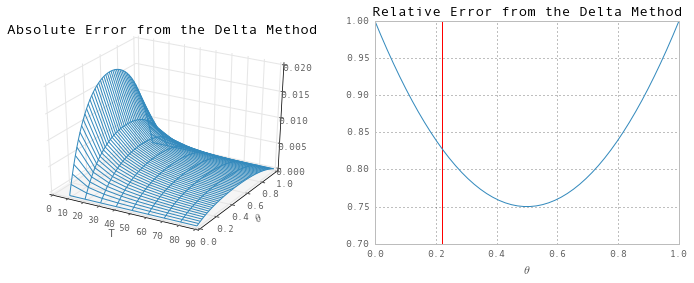

In [23]:
fig = plt.figure(figsize=(12,4))

# Absolute Error
ax = fig.add_subplot(121, projection='3d')
delta = 0.025
T_range = np.arange(0, 100, 10)
TH_range = np.linspace(0, 1)
T_grid, TH_grid = np.meshgrid(T_range, TH_range)
E_grid = (TH_grid*(1-TH_grid) - (TH_grid*(1-TH_grid))**2)/T_grid
ax.plot_wireframe(T_grid, TH_grid, E_grid, color='#348ABD')
ax.set(title='Absolute Error from the Delta Method', xlabel='T', ylabel=r"$\theta$")
ax.xaxis.set(pane_color=(1,1,1))
ax.yaxis.set(pane_color=(1,1,1))

# Relative Error
ax = fig.add_subplot(122)
X = np.linspace(0,1)
ax.plot(X, 1 - X*(1-X))
ax.set(title='Relative Error from the Delta Method', xlabel=r"$\theta$", ylim=(0.7, 1))
ax.vlines(theta_hat_analytic, 0.7, 1, 'r');

So, although the absolute error decreases with the sample size T, the relative error is independent of T. At the analytic solution to the MLE problem (0.22), the relative error is about 82%.

#### Numeric MLE
Setup for the optimization:

In [24]:
# MLE via scipy optimization
from scipy import optimize

# Create transformation functions
transform = lambda phi: np.exp(phi)/(1 + np.exp(phi))
transform_grad = lambda phi: np.exp(phi) / ((1 + np.exp(phi))**2)

# Create functions for the optimizer to call
# (negative because we are using minimizing optimizers)
f = lambda params: -_loglike(transform(params[0]), nobs, Y.sum())
fprime = lambda params: np.matrix(-_score(transform(params[0]), nobs, Y.sum()))
fhess = lambda params: np.matrix(-_hessian(transform(params[0]), nobs, Y.sum()))

There are many different optimization algorithms in `scipy.optimize`; this just demonstrates two of them.

- The [Newton-CG method](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_ncg.html) requires at least the gradient of the function to optimize, and can optionally accept the hessian (otherwise the hessian is numerically approximated from the gradient). It does not return the hessian evaluated at the optimizing parameters (so the delta method cannot be used on this output).
- The [BFGS method](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html) does not require the gradient, and does not accept the hessian. If the gradient is not provided, it is numerically approximated. It returns the inverse of the hessian, which either can be used as the variance / covariance matrix, or can be used to calculate the it via the delta method if there is a transformation involved.

In [25]:
# Run MLE via Newton-CG Method
#%timeit res_ncg = optimize.fmin_ncg(f, np.array([0.5]), fprime, fhess=fhess, disp=False)
print 'Timing: 10 loops, best of 3: 52.2 ms per loop'
res_ncg = optimize.fmin_ncg(f, np.array([0.5]), fprime, fhess=fhess)[0]
var_ncg = np.linalg.inv(-_hessian(transform(res_ncg), nobs, Y.sum()))[0,0]

print 'Newton-CG MLE Estimate: %.2f (%.10f)' % (transform(res_ncg), var_ncg**0.5)

Timing: 10 loops, best of 3: 52.2 ms per loop
Optimization terminated successfully.
         Current function value: 52.690796
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 85
         Hessian evaluations: 35
Newton-CG MLE Estimate: 0.22 (0.0414252425)


In [26]:
# Run MLE via BFGS Method
#%timeit res_bfgs = optimize.fmin_bfgs(f, np.array([0.5]), fprime=fprime, disp=False)
print 'Timing: 100 loops, best of 3: 6.43 ms per loop'
res_bfgs_full = optimize.fmin_bfgs(f, np.array([0.5]), fprime=fprime, full_output=True)
res_bfgs = res_bfgs_full[0]
est_var_bfgs = res_bfgs_full[3]

# Get variance/covariance matrix by inverting the information matrix
var_bfgs = np.linalg.inv(-_hessian(transform(res_bfgs), nobs, Y.sum()))[0,0]
# Get variance/covariance matrix by the delta method
var_bfgs_delta = (transform_grad(res_bfgs)**2 * est_var_bfgs)[0,0]

print 'BFGS MLE Estimate: %.2f (%.10f)' % (transform(res_bfgs), var_bfgs**0.5)
print 'BFGS MLE Estimate (delta): %.2f (%.10f)' % (transform(res_bfgs), var_bfgs_delta**0.5)

Timing: 100 loops, best of 3: 6.43 ms per loop
Optimization terminated successfully.
         Current function value: 52.690796
         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 14
BFGS MLE Estimate: 0.22 (0.0414246308)
BFGS MLE Estimate (delta): 0.22 (0.0171532173)


Notice the error in the approximated variance of the error term matches what we calculated analytically for the error of the delta method, above.

In [27]:
absolute_error = var_bfgs - var_bfgs_delta
relative_error = (var_bfgs - var_bfgs_delta) / var_bfgs

print absolute_error
print relative_error

0.00142176717404
0.828535631545


#### Numeric MLE: Statsmodels

We can also perform MLE using the [Statsmodels](https://github.com/statsmodels/statsmodels) package. It can use any of the `scipy.optimize` methods (e.g. ncg and bfgs, above), but by default it uses its own implementation of the simple Newton-Raphson method. The Newton-Raphson method is very fast but less robust.

In [28]:
# MLE via Statsmodels framework
from statsmodels.base.model import LikelihoodModel

class Bernoulli(LikelihoodModel):
    _loglike = lambda self, theta, T, s: _loglike(theta, T, s)
    _score = lambda self, theta, T, s: _score(theta, T, s)
    _hessian = lambda self, theta, T, s: _hessian(theta, T, s)
    
    def __init__(self, endog, exog=None, **kwargs):
        endog = np.asarray(endog)
        super(Bernoulli, self).__init__(endog, exog, **kwargs)
        self.T = self.endog.shape[0]
        self.s = self.endog.sum()
    
    def loglike(self, params):
        """
        Joint log-likelihood for Bernoulli trials
        """
        return self._loglike(params[0], self.T, self.s)
    
    def score(self, params):
        """
        Gradient of the joint log-likelihood for Bernoulli trials
        """
        return self._score(params[0], self.T, self.s)
        
    def hessian(self, params):
        """
        Hessian of the joint log-likelihood for Bernoulli trials
        """
        return np.matrix(self._hessian(params[0], self.T, self.s))
    
mod = Bernoulli(Y)
#%timeit res = mod.fit(start_params=[0.5], disp=False)
print 'Timing: 1000 loops, best of 3: 1.19 ms per loop'
res = mod.fit(start_params=[0.5])
# Run MLE via Newton-Raphson method
print 'Statsmodels MLE Estimate: %.2f (%.10f)' % (res.params[0,0], res.bse[0])

Timing: 1000 loops, best of 3: 1.19 ms per loop
Optimization terminated successfully.
         Current function value: 0.526908
         Iterations 2
Statsmodels MLE Estimate: 0.22 (0.0414246304)


### Appendix

#### Analytic MLE: Model

<a name="analytic_mle"></a>

$$
\begin{align}
L(\theta;Y) & = \theta^{s} (1 - \theta)^{T-s} & \text{Likelihood} \\
\log L(\theta;Y) & = s \log \theta + (T - s) \log (1 - \theta) & \text{Log-likelihood} \\
\frac{\partial \log L(\theta;Y)}{\partial \theta} & = \frac{s}{\theta} - \frac{T-s}{1 - \theta} & \text{Score} \\
& = s \theta^{-1} - (T-s)(1-\theta)^{-1} & \\
H(\theta) = \frac{\partial^2 \log L(\theta;Y)}{\partial \theta^2} & = -s \theta^{-2} - (T-s)(1-\theta)^{-2} & \text{Hessian} \\
I[\theta] = -E\left [ H(\theta) \right ] & = -E[-s \theta^{-2} - (T-s)(1-\theta)^{-2}] & \text{Information} \\
& = (\theta T) \theta^{-2} + (T-(\theta T))(1-\theta)^{-2} & \\
& = T \frac{1 - \theta + \theta}{\theta (1 - \theta)} & \\
& = \frac{T}{\theta (1 - \theta)} & \\
I[\theta]^{-1} & = \frac{\theta (1-\theta)}{T} & \text{Variance/Covariance}
\end{align}
$$

#### Analytic MLE: First-Order Conditions

<a name="foc"></a>

$$
\begin{align}
0 & = \left . \frac{\partial \log L(\theta;Y)}{\partial \theta} \right |_{\hat \theta_\text{MLE}} \\
0 & = s \hat \theta_\text{MLE}^{-1} - (T-s)(1-\hat \theta_\text{MLE})^{-1} \\
(T-s)(1- \hat \theta_\text{MLE})^{-1} & = s \hat \theta_\text{MLE}^{-1} \\
(T-s) \hat \theta_\text{MLE} & = s (1 - \hat \theta_\text{MLE}) \\
T \hat \theta_\text{MLE} - s \hat \theta_\text{MLE} & = s - s \hat \theta_\text{MLE} \\
\hat \theta_\text{MLE} & = \frac{s}{T} \\
\end{align}
$$

#### Analytic MLE: Transformation Gradient

<a name="trans_grad"></a>

$$
\begin{align}
\frac{\partial g(\varphi)}{\partial \varphi} & = \frac{\partial e^\varphi (1 + e^\varphi)^{-1}}{\partial \varphi} = e^\varphi (-1) (1 + e^\varphi)^{-2} e^\varphi + (1 + e^\varphi)^{-1} e^\varphi \\
& = \frac{e^\varphi}{1 + e^\varphi} - \frac{e^\varphi e^\varphi}{(1 + e^\varphi)^2} = \frac{(1 + e^\varphi) e^\varphi - e^\varphi e^\varphi}{(1 + e^\varphi)^2} = e^\varphi \frac{(1 + e^\varphi) - e^\varphi}{(1 + e^\varphi)^2} \\
& = \frac{e^\varphi}{(1 + e^\varphi)^2}\\
\end{align}
$$

#### Analytic MLE: Transformation Inverse

<a name="trans_inv"></a>

$$
\begin{align}
\theta & = g(\varphi) = \frac{e^\varphi}{1 + e^\varphi}\\
(1 + e^\varphi) \theta & = e^\varphi \\
\theta & = e^\varphi (1 - \theta) \\
\varphi & = \log \left (\frac{\theta}{1 - \theta} \right ) = g^{-1}(\theta) \\
\end{align}
$$


#### Analytic MLE: Model (Unconstrained Parameter)

<a name="mle_uncon"></a>

$$
\begin{align}
L(g(\varphi);Y) & = g(\varphi)^{s} (1 - g(\varphi))^{T-s} & \text{Likelihood} \\
\log L(g(\varphi);Y) & = s \log g(\varphi) + (T - s) \log (1 - g(\varphi)) & \text{Log-likelihood} \\
\frac{\partial \log L(g(\varphi);Y)}{\partial g(\varphi)} & = \frac{\partial \log L(g(\varphi);Y)}{\partial \theta} \frac{\partial g(\varphi)}{\partial \varphi} & \text{Score}\\
& = \left ( \frac{s}{g(\varphi)} - \frac{T-s}{1 - g(\varphi)} \right ) \frac{e^\varphi}{(1 + e^\varphi)^2} & \\
& = \left ( \frac{s(1 + e^\varphi)}{e^\varphi} - \frac{(T-s)}{1 - e^\varphi/(1 + e^\varphi)} \right ) \frac{e^\varphi}{(1 + e^\varphi)^2} & \\
& = \left ( \frac{s(1 + e^\varphi)}{e^\varphi} - \frac{(T-s)(1 + e^\varphi)}{1 + e^\varphi - e^\varphi} \right ) \frac{e^\varphi}{(1 + e^\varphi)^2} & \\
& = \left ( \frac{s - (T-s) e^\varphi}{1 + e^\varphi} \right ) & \\
& = \left ( \frac{s (1 + e^\varphi)  - T e^\varphi}{1 + e^\varphi} \right ) & \\
& = \left ( s - T \frac{e^\varphi}{1 + e^\varphi} \right ) & \\
& = s - T g(\varphi) & \\
H(\varphi) = \frac{\partial^2 \log L(g(\varphi);Y)}{\partial g(\varphi)^2} & = -T & \text{Hessian}\\
I[\varphi] = -E\left [ H(\varphi) \right ] & = T & \text{Information} \\
I[\varphi]^{-1} & = \frac{1}{T} & \text{Variance/Covariance}
\end{align}
$$

#### Analytic MLE: Delta Method

<a name="delta"></a>

$$
\begin{align}
I_\text{Delta}[\hat \theta_\text{MLE}]^{-1} & = \left . \frac{\partial g(\varphi)}{\partial \varphi} \right |_{\varphi_\text{MLE}} \times I[\varphi]^{-1} \times \left . \frac{\partial g(\varphi)}{\partial \varphi}^T \right |_{\varphi_\text{MLE}} \\
& = \left ( \frac{\exp \left [ \log \left (\frac{\hat \theta_\text{MLE}}{1-\hat \theta_\text{MLE}} \right ) \right ]}{\left (1 + \exp \left [ \log \left (\frac{\hat \theta_\text{MLE}}{1-\hat \theta_\text{MLE}} \right ) \right ] \right )^2} \right )^2 \frac{1}{T} = \left ( \frac{\hat \theta_\text{MLE}}{1-\hat \theta_\text{MLE}} \left (1 + \frac{\hat \theta_\text{MLE}}{1-\hat \theta_\text{MLE}} \right )^{-2} \right )^2 \frac{1}{T} \\
& = \left ( \frac{\hat \theta_\text{MLE}}{1-\hat \theta_\text{MLE}} \left (1-\hat \theta_\text{MLE} \right )^2 \right )^2 \frac{1}{T} = \left (\hat \theta_\text{MLE} (1-\hat \theta_\text{MLE}) \right )^2 \frac{1}{T} \\
& = I[\hat \theta_\text{MLE}]^{-1} \left (\hat \theta_\text{MLE} (1-\hat \theta_\text{MLE}) \right ) \\
\end{align}
$$